In [1]:
import sys, os
from pathlib import Path
import numpy as np
import ee
from joblib import Memory
from google.cloud import storage

sys.path.append(os.path.abspath(".."))
# Resolve all data paths relative to the repo root
REPO_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]

from config import load_city_config
from gee_utils import (
    init_gee,  
    load_image_collection, 
)
from mappluto import load_and_sample
from dependencies import get_nyc_geometry
from naip import calculate_spectral_indices
from raster_utils import create_parcel_raster, get_parcel_raster_stats
from analysis import (
    cluster_spectral_data,
    analyze_cluster_composition,
)

In [2]:
memory = Memory(Path("cache"), verbose=0)

# Load city config (contains all settings including GCP)
CONFIG = load_city_config("nyc", config_dir=REPO_ROOT / "config")
print(f"Loaded config for: {CONFIG.city_name}")

# gcs client
client = storage.Client()
bucket = client.bucket(CONFIG.gcp.bucket)

18:01:37 | INFO | vacant_lots | Loaded city config for: nyc
Loaded config for: New York City


In [3]:
init_gee(CONFIG.gcp)

18:01:39 | INFO | vacant_lots | Initializing GEE with ADC credentials and project:vacant-lot-detection
18:01:40 | INFO | vacant_lots | GEE sucessfully initialized


# !!!! set proj fron NAIP or put it in the config

In [4]:
"""
- Load MapPLUTO (NYC) 2022 v3 -- fall matches with NAIP
- Calculate perimeter of lot
- Subset by area for EDA: 2000 < Shape_Area < 16000
- Sample vacant (LandUse 11) up to 8%
- Convert CRS: (NYC ft) EPSG:2263 --> (WGS84) EPSG:4326
"""
mappluto_22_path = CONFIG.get_parcel_path(REPO_ROOT)
mappluto_22_gdf, sampled_gdf = load_and_sample(mappluto_22_path, layer=CONFIG.parcel.layer)

18:01:50 | INFO | vacant_lots | Loaded /Users/joyadebi/repos/Vacant_Lot_Detection/data/nyc_mappluto_22v3_arc_fgdb/MapPLUTO22v3.gdb
18:01:51 | INFO | vacant_lots | added geom_perimeter column
18:01:51 | INFO | vacant_lots | Resampling class 11: 0.022393368977976332 -> 0.08
18:01:52 | INFO | vacant_lots | Sampled sucessfully
18:01:52 | INFO | vacant_lots | Sampling LandUse 11 to 0.08
18:01:52 | INFO | vacant_lots | Converting CRS: EPSG:2263, EPSG:2263 --> EPSG:4326


/Users/joyadebi/repos/Vacant_Lot_Detection/mappluto.py:203: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_gdf = (gdf.groupby(landuse_col, group_keys=False).apply(lambda grp: grp.sample(n=min(target_per_class.get(grp.name,0), len(grp)), random_state=random_state)))


In [6]:
nyc_geom = get_nyc_geometry()

@memory.cache
def get_naip_2022_nyc():
    return load_image_collection(
        collection_id="USDA/NAIP/DOQQ",
        start_date="2022-01-01",
        end_date="2022-12-31",
        region=nyc_geom,
        mosaic=True
    )

naip_2022_nyc = get_naip_2022_nyc()
naip_2022_nyc = calculate_spectral_indices(naip_2022_nyc, CONFIG)


18:02:04 | INFO | vacant_lots | scaling ['R', 'G', 'B', 'N'] by 255.0
18:02:04 | INFO | vacant_lots | calculating NDVI
18:02:04 | INFO | vacant_lots | scaling NDVI to [0,1]
18:02:04 | INFO | vacant_lots | calculating SAVI
18:02:04 | INFO | vacant_lots | clamping SAVI values [-1, 1]
18:02:04 | INFO | vacant_lots | scaling SAVI values to [0,1]
18:02:04 | INFO | vacant_lots | calculating brightness
18:02:04 | INFO | vacant_lots | Added NDVI, SAVI, BRIGHTNESS bands
18:02:04 | INFO | vacant_lots | Added Bare Soil Proxy bands


In [ ]:
## convert to .shp or .zip -> gcs -> gee table injestion
import geopandas as gpd
import zipfile 
from pathlib import Path
#make minimal gdf copy with identifier to send as feature collection
minimal_gdf = sampled_gdf[["BBL", "geometry"]].copy()

#shp file does not like long ints, but can handle long text fields (254 chars)
minimal_gdf["BBL"] = minimal_gdf["BBL"].astype(str)
# TODO use config here, and write function so the o ut_dir and zip_file can be done in the same function
out_dir = Path("intermediaries")
out_dir.mkdir(parents=True, exist_ok=True)

# write shapefile --> GEE can only injest .shp or.zip as table 11-30-2025
# https://developers.google.com/earth-engine/guides/table_upload 
shp_path = out_dir / "nyc_parcels.shp"
minimal_gdf.to_file(shp_path)

# zip all shapefile component files (GEE needs all to render)
zip_path = Path("nyc_parcels.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for file in out_dir.iterdir():
        z.write(file, arcname=file.name)

# TODO switch to log
print("Created:", zip_path.resolve())


blob = bucket.blob("new_york_new_york/parcels.zip")
blob.upload_from_filename("nyc_parcels.zip")

In [ ]:
# ingest into ee as asset 

manifest = {
  'name': f'projects/{CONFIG.gcp.project_id}/assets/nyc_parcels',
  'sources': [
    {
      'uris': [
        f'gs://{CONFIG.gcp.bucket}/{CONFIG.gee.export_prefix}/parcels.zip'
      ]
    }
  ]
}

task = ee.data.startTableIngestion(None, manifest)
task.start()

In [ ]:
# load parcels from GEE (vector approach - kept for comparison)
parcels = ee.FeatureCollection(f"projects/{CONFIG.gcp.project_id}/assets/nyc_parcels")

reducer = (
    ee.Reducer.mean()
      .combine(ee.Reducer.median(), "", True)
      .combine(ee.Reducer.stdDev(), "", True)
)

stats = naip_2022_nyc.reduceRegions(
    collection=parcels,
    reducer=reducer,
    scale=1,            # NAIP is 1 m
    tileScale=4         # optional: helps avoid memory errors
)

task = ee.batch.Export.table.toCloudStorage(
    collection=stats,
    description='parcel_spectral_stats',
    bucket=CONFIG.gcp.bucket,
    fileNamePrefix=f'{CONFIG.gee.export_prefix}/parcel_spectral_stats',
    fileFormat='CSV'
)
task.start()

# NOTE: Consider using the raster-based approach below for better performance

## Start here to get the Parcel by Parcel Spectral Stats

In [86]:
from io import BytesIO
import pandas as pd
#read csv back from gcs
bucket = client.bucket("thesis_parcels")
blob = bucket.blob("new_york_new_york/parcel_spectral_stats.csv")
spectral_stats = blob.download_as_bytes()
spectral_df = pd.read_csv(BytesIO(spectral_stats))


spectral_df

,system:index,BBL,B_mean,B_median,B_stdDev,BareSoilProxy_mean,BareSoilProxy_median,BareSoilProxy_stdDev,Brightness_mean,Brightness_median,...,N_mean,N_median,N_stdDev,R_mean,R_median,R_stdDev,SAVI_mean,SAVI_median,SAVI_stdDev,.geo
0,00000000000000000000,4.123580e+09,0.465704,0.454902,0.117890,0.211656,0.210208,0.080850,0.494437,0.494118,...,0.707190,0.780392,0.146821,0.512659,0.529412,0.154286,0.586653,0.578902,0.069294,"{""type"":""Polygon"",""coordinates"":[[[-73.7809682..."
1,00000000000000000001,4.012190e+09,0.597727,0.552941,0.200351,0.281735,0.289528,0.123735,0.600278,0.595793,...,0.703934,0.776471,0.148594,0.600467,0.643137,0.217222,0.550289,0.510577,0.080678,"{""type"":""Polygon"",""coordinates"":[[[-73.8985636..."
2,00000000000000000002,5.056480e+09,0.568533,0.521569,0.156918,0.266584,0.265051,0.098910,0.541939,0.517658,...,0.526048,0.505882,0.156423,0.510595,0.509804,0.198126,0.513066,0.505017,0.043212,"{""type"":""Polygon"",""coordinates"":[[[-74.1754694..."
3,00000000000000000003,5.012210e+09,0.404818,0.325490,0.176323,0.165929,0.120125,0.117723,0.399402,0.360507,...,0.571719,0.576471,0.186706,0.374750,0.345098,0.210784,0.611633,0.636303,0.087998,"{""type"":""Polygon"",""coordinates"":[[[-74.1567010..."
4,00000000000000000004,4.140100e+09,0.656533,0.709804,0.153301,0.302134,0.334840,0.094974,0.651812,0.685819,...,0.712123,0.784314,0.146762,0.629338,0.701961,0.200118,0.541620,0.508660,0.058378,"{""type"":""Polygon"",""coordinates"":[[[-73.8431370..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,0000000000000000619b,2.034750e+09,0.484465,0.435294,0.138759,0.208742,0.186044,0.081217,0.487510,0.474365,...,0.642356,0.749020,0.214177,0.461490,0.474510,0.174029,0.582365,0.588689,0.065897,"{""type"":""Polygon"",""coordinates"":[[[-73.8554263..."
24988,0000000000000000619c,4.086680e+09,0.470214,0.466667,0.069660,0.203471,0.201608,0.066492,0.478017,0.484967,...,0.669767,0.749020,0.181570,0.482918,0.498039,0.156422,0.584664,0.565321,0.067416,"{""type"":""Polygon"",""coordinates"":[[[-73.7143716..."
24989,0000000000000000619d,4.081620e+09,0.318125,0.325490,0.043786,0.101444,0.102040,0.038712,0.342755,0.352265,...,0.789981,0.815686,0.082401,0.325094,0.329412,0.099068,0.719262,0.718211,0.041057,"{""type"":""Polygon"",""coordinates"":[[[-73.7436143..."
24990,0000000000000000619e,5.065080e+09,0.341140,0.337255,0.026111,0.098491,0.093207,0.030028,0.344871,0.340387,...,0.809808,0.815686,0.044572,0.319720,0.309804,0.078560,0.728009,0.729894,0.035832,"{""type"":""Polygon"",""coordinates"":[[[-74.1809050..."


In [88]:
mappluto_features = sampled_gdf[["BBL", "LandUse", "geometry", "geom_perimeter", "Shape_Area"]].copy()
mappluto_features

,BBL,LandUse,geometry,geom_perimeter,Shape_Area
680602,4.123580e+09,01,"MULTIPOLYGON (((-73.78065 40.68114, -73.78097 ...",308.918117,5641.319343
549104,4.012190e+09,01,"MULTIPOLYGON (((-73.89856 40.7473, -73.89891 4...",262.202686,3019.511824
793718,5.056480e+09,01,"MULTIPOLYGON (((-74.17542 40.55885, -74.17547 ...",247.168215,2604.183119
826063,5.012210e+09,01,"MULTIPOLYGON (((-74.15711 40.62947, -74.15669 ...",322.069528,5311.433310
601017,4.140100e+09,01,"MULTIPOLYGON (((-73.84298 40.65711, -73.84314 ...",289.746860,4426.423552
...,...,...,...,...,...
64000,2.034750e+09,11,"MULTIPOLYGON (((-73.85543 40.81238, -73.85544 ...",272.588380,2569.428282
691366,4.086680e+09,11,"MULTIPOLYGON (((-73.71423 40.72829, -73.71428 ...",195.072631,2068.498227
481333,4.081620e+09,11,"MULTIPOLYGON (((-73.74337 40.77485, -73.74341 ...",295.646550,2603.504172
719128,5.065080e+09,11,"MULTIPOLYGON (((-74.18059 40.5314, -74.1809 40...",240.002954,2000.031627


In [90]:
# spectral only clustering 
mappluto_spectral_df = mappluto_features[["BBL", "LandUse"]].copy()

#join on bbl with spectral df 
merged_df = spectral_df.merge(mappluto_spectral_df, on="BBL", how="left")
merged_df

,system:index,BBL,B_mean,B_median,B_stdDev,BareSoilProxy_mean,BareSoilProxy_median,BareSoilProxy_stdDev,Brightness_mean,Brightness_median,...,N_median,N_stdDev,R_mean,R_median,R_stdDev,SAVI_mean,SAVI_median,SAVI_stdDev,.geo,LandUse
0,00000000000000000000,4.123580e+09,0.465704,0.454902,0.117890,0.211656,0.210208,0.080850,0.494437,0.494118,...,0.780392,0.146821,0.512659,0.529412,0.154286,0.586653,0.578902,0.069294,"{""type"":""Polygon"",""coordinates"":[[[-73.7809682...",01
1,00000000000000000001,4.012190e+09,0.597727,0.552941,0.200351,0.281735,0.289528,0.123735,0.600278,0.595793,...,0.776471,0.148594,0.600467,0.643137,0.217222,0.550289,0.510577,0.080678,"{""type"":""Polygon"",""coordinates"":[[[-73.8985636...",01
2,00000000000000000002,5.056480e+09,0.568533,0.521569,0.156918,0.266584,0.265051,0.098910,0.541939,0.517658,...,0.505882,0.156423,0.510595,0.509804,0.198126,0.513066,0.505017,0.043212,"{""type"":""Polygon"",""coordinates"":[[[-74.1754694...",01
3,00000000000000000003,5.012210e+09,0.404818,0.325490,0.176323,0.165929,0.120125,0.117723,0.399402,0.360507,...,0.576471,0.186706,0.374750,0.345098,0.210784,0.611633,0.636303,0.087998,"{""type"":""Polygon"",""coordinates"":[[[-74.1567010...",01
4,00000000000000000004,4.140100e+09,0.656533,0.709804,0.153301,0.302134,0.334840,0.094974,0.651812,0.685819,...,0.784314,0.146762,0.629338,0.701961,0.200118,0.541620,0.508660,0.058378,"{""type"":""Polygon"",""coordinates"":[[[-73.8431370...",01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,0000000000000000619b,2.034750e+09,0.484465,0.435294,0.138759,0.208742,0.186044,0.081217,0.487510,0.474365,...,0.749020,0.214177,0.461490,0.474510,0.174029,0.582365,0.588689,0.065897,"{""type"":""Polygon"",""coordinates"":[[[-73.8554263...",11
24988,0000000000000000619c,4.086680e+09,0.470214,0.466667,0.069660,0.203471,0.201608,0.066492,0.478017,0.484967,...,0.749020,0.181570,0.482918,0.498039,0.156422,0.584664,0.565321,0.067416,"{""type"":""Polygon"",""coordinates"":[[[-73.7143716...",11
24989,0000000000000000619d,4.081620e+09,0.318125,0.325490,0.043786,0.101444,0.102040,0.038712,0.342755,0.352265,...,0.815686,0.082401,0.325094,0.329412,0.099068,0.719262,0.718211,0.041057,"{""type"":""Polygon"",""coordinates"":[[[-73.7436143...",11
24990,0000000000000000619e,5.065080e+09,0.341140,0.337255,0.026111,0.098491,0.093207,0.030028,0.344871,0.340387,...,0.815686,0.044572,0.319720,0.309804,0.078560,0.728009,0.729894,0.035832,"{""type"":""Polygon"",""coordinates"":[[[-74.1809050...",11


In [91]:
# Preview the spectral features that will be used for clustering
# (The actual feature extraction is handled by the analysis module)
feature_cols = CONFIG.clustering.features if CONFIG.clustering else [c for c in merged_df.columns if c.endswith("_mean")]
print(f"Features for clustering: {feature_cols}")
merged_df[feature_cols].describe()

Features for clustering: ['B_mean', 'G_mean', 'R_mean', 'N_mean', 'NDVI_mean', 'SAVI_mean', 'Brightness_mean', 'BareSoilProxy_mean']


,B_mean,G_mean,R_mean,N_mean,NDVI_mean,SAVI_mean,Brightness_mean,BareSoilProxy_mean
count,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000
mean,0.560593,0.563987,0.548439,0.642963,0.544354,0.544976,0.557673,0.263041
std,0.108907,0.108030,0.117486,0.098384,0.050116,0.047841,0.110291,0.066386
min,0.234142,0.153241,0.114791,0.040158,0.248541,0.335779,0.170082,0.045796
25%,0.484511,0.488148,0.467896,0.583195,0.510845,0.511601,0.481536,0.218882
50%,0.555253,0.559658,0.546417,0.649901,0.537838,0.537704,0.553322,0.263237
75%,0.639528,0.641712,0.633319,0.714452,0.570333,0.569437,0.636651,0.311035
max,0.893694,0.894698,0.886300,0.892276,0.773154,0.759789,0.891564,0.444620


In [92]:
# Using the analysis module for clustering
# This replaces the manual KMeans + PCA code with the formalized pipeline

merged_df = cluster_spectral_data(
    df=merged_df,
    feature_columns=CONFIG.clustering.features if CONFIG.clustering else None,
    n_clusters=CONFIG.clustering.n_clusters if CONFIG.clustering else 5,
    random_state=CONFIG.clustering.random_state if CONFIG.clustering else 42,
    add_pca=True,
)
merged_df

18:10:58 | INFO | vacant_lots | Starting spectral clustering pipeline
18:10:58 | INFO | vacant_lots | Filling 8 NaN values with column medians
18:10:58 | INFO | vacant_lots | Features: ['B_mean', 'G_mean', 'R_mean', 'N_mean', 'NDVI_mean', 'SAVI_mean', 'Brightness_mean', 'BareSoilProxy_mean']
18:10:58 | INFO | vacant_lots | Fitting new StandardScaler
18:10:58 | INFO | vacant_lots | Running KMeans with 5 clusters
18:10:58 | INFO | vacant_lots |   Cluster 0: 2477 samples (9.9%)
18:10:58 | INFO | vacant_lots |   Cluster 1: 3653 samples (14.6%)
18:10:58 | INFO | vacant_lots |   Cluster 2: 7644 samples (30.6%)
18:10:58 | INFO | vacant_lots |   Cluster 3: 5175 samples (20.7%)
18:10:58 | INFO | vacant_lots |   Cluster 4: 6043 samples (24.2%)
18:10:58 | INFO | vacant_lots | Running PCA with 2 components
18:10:58 | INFO | vacant_lots |   PC1 explained variance: 75.7%
18:10:58 | INFO | vacant_lots |   PC2 explained variance: 22.9%
18:10:58 | INFO | vacant_lots |   Total explained variance: 98.7%


,system:index,BBL,B_mean,B_median,B_stdDev,BareSoilProxy_mean,BareSoilProxy_median,BareSoilProxy_stdDev,Brightness_mean,Brightness_median,...,R_median,R_stdDev,SAVI_mean,SAVI_median,SAVI_stdDev,.geo,LandUse,cluster,pc1,pc2
0,00000000000000000000,4.123580e+09,0.465704,0.454902,0.117890,0.211656,0.210208,0.080850,0.494437,0.494118,...,0.529412,0.154286,0.586653,0.578902,0.069294,"{""type"":""Polygon"",""coordinates"":[[[-73.7809682...",01,4,-1.582996,1.029345
1,00000000000000000001,4.012190e+09,0.597727,0.552941,0.200351,0.281735,0.289528,0.123735,0.600278,0.595793,...,0.643137,0.217222,0.550289,0.510577,0.080678,"{""type"":""Polygon"",""coordinates"":[[[-73.8985636...",01,2,0.769507,0.693041
2,00000000000000000002,5.056480e+09,0.568533,0.521569,0.156918,0.266584,0.265051,0.098910,0.541939,0.517658,...,0.509804,0.198126,0.513066,0.505017,0.043212,"{""type"":""Polygon"",""coordinates"":[[[-74.1754694...",01,1,-0.068484,-1.462005
3,00000000000000000003,5.012210e+09,0.404818,0.325490,0.176323,0.165929,0.120125,0.117723,0.399402,0.360507,...,0.345098,0.210784,0.611633,0.636303,0.087998,"{""type"":""Polygon"",""coordinates"":[[[-74.1567010...",01,0,-3.864605,0.442367
4,00000000000000000004,4.140100e+09,0.656533,0.709804,0.153301,0.302134,0.334840,0.094974,0.651812,0.685819,...,0.701961,0.200118,0.541620,0.508660,0.058378,"{""type"":""Polygon"",""coordinates"":[[[-73.8431370...",01,2,1.729219,0.831644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,0000000000000000619b,2.034750e+09,0.484465,0.435294,0.138759,0.208742,0.186044,0.081217,0.487510,0.474365,...,0.474510,0.174029,0.582365,0.588689,0.065897,"{""type"":""Polygon"",""coordinates"":[[[-73.8554263...",11,4,-1.780510,0.522362
24988,0000000000000000619c,4.086680e+09,0.470214,0.466667,0.069660,0.203471,0.201608,0.066492,0.478017,0.484967,...,0.498039,0.156422,0.584664,0.565321,0.067416,"{""type"":""Polygon"",""coordinates"":[[[-73.7143716...",11,4,-1.913703,0.668133
24989,0000000000000000619d,4.081620e+09,0.318125,0.325490,0.043786,0.101444,0.102040,0.038712,0.342755,0.352265,...,0.329412,0.099068,0.719262,0.718211,0.041057,"{""type"":""Polygon"",""coordinates"":[[[-73.7436143...",11,0,-5.831925,3.747472
24990,0000000000000000619e,5.065080e+09,0.341140,0.337255,0.026111,0.098491,0.093207,0.030028,0.344871,0.340387,...,0.309804,0.078560,0.728009,0.729894,0.035832,"{""type"":""Polygon"",""coordinates"":[[[-74.1809050...",11,0,-5.867900,4.028752


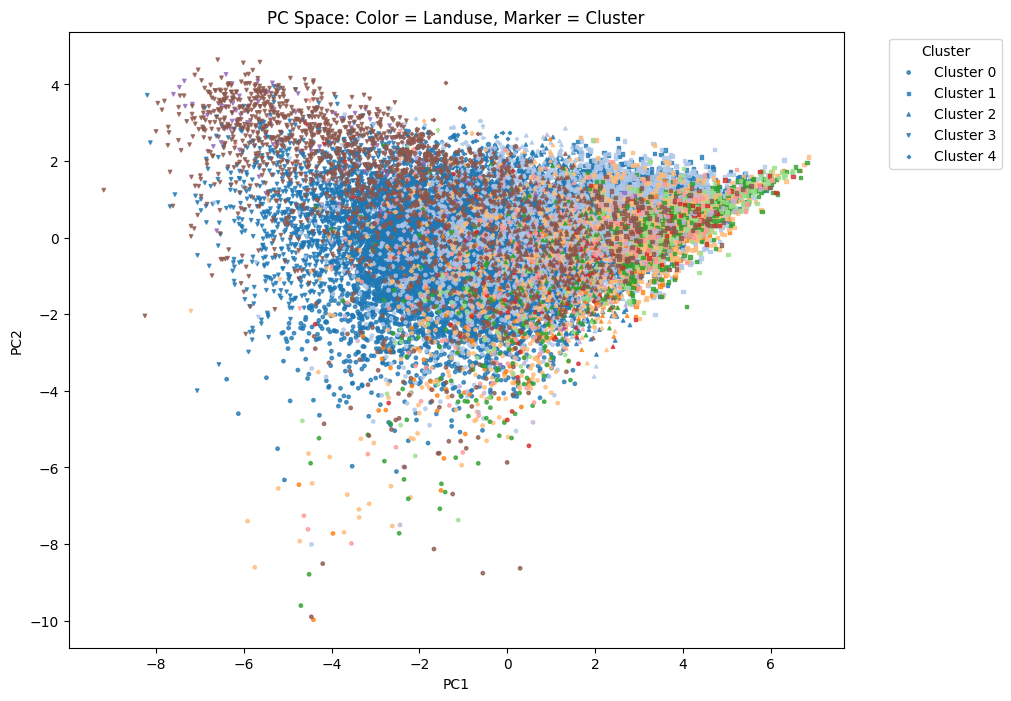

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# unique categories
landuse_classes = sorted(merged_df["LandUse"].unique())
clusters = sorted(merged_df["cluster"].unique())

# assign each landuse a color
cmap = plt.get_cmap("tab20")
color_map = {lu: cmap(i % 20) for i, lu in enumerate(landuse_classes)}

# assign each cluster a marker
markers = ["o", "s", "^", "v", "P", "D", "*", "X", "<", ">"]
marker_map = {cl: markers[i % len(markers)] for i, cl in enumerate(clusters)}

plt.figure(figsize=(10, 8))

for cl in clusters:
    subset = merged_df[merged_df["cluster"] == cl]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        c=subset["LandUse"].map(color_map),
        marker=marker_map[cl],
        s=6,
        alpha=0.75,
        label=f"Cluster {cl}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC Space: Color = Landuse, Marker = Cluster")

# legend for cluster markers
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


In [ ]:
# Analyze cluster composition using the analysis module
composition = analyze_cluster_composition(merged_df, cluster_col="cluster", category_col="LandUse")

composition.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
plt.title("Landuse composition per cluster")
plt.ylabel("Fraction")
plt.show()

# Show the composition table
composition

In [ ]:
#vegetation fraction 
# Optional but safe:

# number of NAIP pixels in parcel

# vegetation fraction (proportion NDVI > 0.2 or SAVI > 0.25)

# Raster Attempt

## CRS - UTM 18 (1M Projected Coordinate System) EPSG:32618

In [ ]:
# need parcel_id.tif 
# CRS = EPSG:32618 UTM 18 
# resoluion = Naip resolution (1m)
# pixel value = parcel ID (int)
# background = 0 

In [ ]:
import rasterio

proj = naip_2022_nyc.projection().getInfo()
proj

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

In [ ]:
mappluto_22_gdf.total_bounds

array([-74.25575739,  40.49591592, -73.70017605,  40.91544196])

In [ ]:
# TODO fix preojections of naip and mappluto when recieved -- add itr to configs

array([ 563055.6183248 , 4483073.81190344,  609747.78199494,
       4529941.82144713])

In [ ]:
import pandas as pd

# Rasterize parcels using the raster_utils module
# This creates a GeoTIFF where each parcel polygon has a unique integer ID

raster_output_path = Path(CONFIG.raster.output_path) if CONFIG.raster.output_path else Path("nyc_parcels_utm18n.tif")

# Only create if it doesn't exist (skip if already created)
if not raster_output_path.exists():
    raster_path, id_mapping = create_parcel_raster(
        gdf=mappluto_22_gdf,
        id_column=CONFIG.parcel.id_column,
        output_path=raster_output_path,
        resolution=CONFIG.raster.resolution,
        crs=CONFIG.raster.output_crs,
    )
    
    # Save the ID mapping for later use
    id_mapping.to_csv("intermediaries/parcel_id_mapping.csv", index=False)
    print(f"Created parcel raster: {raster_path}")
    print(f"ID mapping shape: {id_mapping.shape}")
else:
    print(f"Parcel raster already exists: {raster_output_path}")
    # Load existing mapping if available
    mapping_path = Path("intermediaries/parcel_id_mapping.csv")
    if mapping_path.exists():
        id_mapping = pd.read_csv(mapping_path)
        print(f"Loaded existing ID mapping: {id_mapping.shape}")

## Raster-Based Parcel Reduction

Instead of using `reduceRegions()` with vector polygons (which is slow for many parcels), we can use a grouped reducer with the parcel raster. This approach:
1. Uploads the parcel raster to GEE as an Image asset
2. Stacks the imagery bands with the parcel ID band
3. Uses `reduceRegion()` with a grouped reducer to compute stats per parcel ID

To upload the raster, run from the repo root:
```bash
python scripts/upload_parcel_raster.py --raster EDA/nyc_parcels_utm18n.tif --asset-name nyc_parcels_raster
```

In [7]:
# Check parcel raster stats (local file)
raster_path = Path("nyc_parcels_utm18n.tif")
if raster_path.exists():
    stats = get_parcel_raster_stats(raster_path)
    print(f"Parcel raster stats:")
    for k, v in stats.items():
        print(f"  {k}: {v}")

18:06:04 | INFO | vacant_lots | Loading parcel raster: nyc_parcels_utm18n.tif
18:06:12 | INFO | vacant_lots | Loaded raster: 46692x46868, CRS: EPSG:32618
18:06:26 | INFO | vacant_lots | Parcel raster stats: 856841 unique parcels
Parcel raster stats:
  total_pixels: 2188360656
  valid_pixels: 586726516
  nodata_pixels: 1601634140
  unique_parcels: 856841
  min_parcel_id: 1
  max_parcel_id: 856998
  crs: EPSG:32618
  bounds: BoundingBox(left=563055.6183247963, bottom=4483073.811903439, right=609747.7819949412, top=4529941.821447134)


In [ ]:
# Example: Using raster-based grouped reducer (run after uploading parcel raster to GEE)
# Uncomment and run once the asset is available

# parcel_raster_asset = CONFIG.gee.parcel_asset
# parcel_raster = load_parcel_raster_asset(parcel_raster_asset)

# # Define bands to reduce
# bands_to_reduce = ['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy']

# # Run grouped reduction on a small test region first
# test_region = nyc_geom  # or a smaller subset for testing

# grouped_stats = reduce_by_parcel_raster(
#     imagery=naip_2022_nyc,
#     parcel_raster=parcel_raster,
#     region=test_region,
#     bands=bands_to_reduce,
#     scale=1,
# )

# # Export results to GCS
# task = export_grouped_stats_to_gcs(
#     stats_dict=grouped_stats,
#     description='parcel_spectral_stats_raster',
#     bucket=CONFIG.gcp.bucket,
#     file_prefix=f'{CONFIG.gee.export_prefix}/parcel_spectral_stats_raster',
# )

In [ ]:
# stats by explicit landuse
mappluto_22_gdb[mappluto_22_gdb["LandUse"] == "11"]["Shape_Area"].describe()
mean = mappluto_22_gdb[mappluto_22_gdb["LandUse"] == "11"]["Shape_Area"].mean()
std = mappluto_22_gdb[mappluto_22_gdb["LandUse"] == "11"]["Shape_Area"].std()

lower_bound = mean - std
upper_bound = mean + std

within_1std = mappluto_22_gdb[
    (mappluto_22_gdb["Shape_Area"] >= lower_bound) &
    (mappluto_22_gdb["Shape_Area"] <= upper_bound)
]
areas = within_1std["Shape_Area"]
within_1std["Shape_Area"].describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(areas, bins=100, color="skyblue", edgecolor="black", alpha=0.7)
plt.yscale("log")  # log scale helps reveal distribution
plt.xlabel("Parcel Area (sqft)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of Vacant Lot Areas Within 1 Std dev (MapPLUTO)")

mean = areas.mean()
std = areas.std()
median = areas.median()
plt.axvline(mean, color="red", linestyle="--", label=f"Mean = {mean:.0f}")
plt.axvline(mean + std, color="orange", linestyle="--", label="+1 Std")
plt.axvline(mean - std, color="orange", linestyle="--", label="-1 Std")
plt.axvline(median, color="blue", linestyle="--", label="median")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# stats by NumBldgs, BldgArea, BuiltFar
# Due to LandUse counts
potential_vacant, lots_to_inspect, vacant_landuse_counts = identify_potential_vacant_lots(mappluto_22_gdb)
potential_vacant["Shape_Area"].describe()

In [ ]:
# Makes sense
# 7: Transportation and Utility
# 9: Open space and Outdoor Recreation
# 10: Parking Facilities
# Doesn't Really Make Sense
# 01,02,03,04,05: Buildings
# 08: Public Facilities and Institutions
# TODO kind of want to look at these lots in pictures
vacant_landuse_counts